In [ ]:
##MODULO MODELING HIPERPARAMETRIZATION:

"""En este módulo se prueban diferentes modelos (algoritmos) de entrenamiento y se analizan sus resultados. Los componentes son:
1. Entrenamiento de cada modelo utilizando GridseacrhCV para encontrar los hiperparámetros óptimos en cada caso
2. Obtención del mejor valor posible de cada modelo entrenado, utilizando como criterios RMSE, MAE, R2, etc
2. Análisis residual gráfico de los resultados para comprobar si se cumplen los supuestos de regresión"""

In [1]:
##Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 350)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)
sns.set(style='darkgrid')
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker


# import all libraries and dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer


import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from sklearn.model_selection import train_test_split


from scipy import stats
from scipy.stats import norm, kurtosis, skew

# Import specific libraries
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from patsy import dmatrices

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


pd.set_option('expand_frame_repr', False)

In [2]:
##ACÁ SE RECIBE LA DATA ACTUALIZADA LISTA DE LA ETAPA ANTERIOR, INCLUYENDO LOS SETS DE FEATURES SELECCIONADOS POR CADA MÉTODO 

#Loading datasets

%store -r all_data
%store -r y_train


#Loading sets de features obtenidos en la etapa de Feature Selection
%store -r pv_cols
%store -r sel_cols_rfecv
%store -r SBS
%store -r kbest_FR
%store -r kbest_MIR
%store -r Xgb_selected_feats
%store -r total_cols

#Loading polynomial_features dataframe
%store -r new_poly_features





In [3]:
###ACTUALIZACION DE TRAIN Y TEST ANTES DE PASAR A MODELING

# #Creo el train y se resetea también su index
train = all_data.round(3).iloc[:len(y_train), :]
train = train.loc[:, list(total_cols)].reset_index(drop = True, inplace = False)

# #Creo el test y se resetea también su index
test = all_data.round(3).iloc[len(y_train):, :]
test= test.loc[:, list(total_cols)].reset_index(drop = True, inplace = False)

# #Reseteo además el y_train en su index

y_train = y_train.reset_index(drop = True, inplace = False)

train.shape

(1449, 190)

In [4]:
#####DIMENSIONALITY REDUCTION VIA PRINCIPAL COMPONENT ANALYSIS

In [5]:
"""Excelente explicación en este link: https://www.youtube.com/watch?v=AniiwysJ-2Y&list=PLs8w1Cdi-zvZ43xD_AA-eAuEW1FLK0cef&index=6"""

'Excelente explicación en este link: https://www.youtube.com/watch?v=AniiwysJ-2Y&list=PLs8w1Cdi-zvZ43xD_AA-eAuEW1FLK0cef&index=6'

In [6]:
#Haremos una reducción dimensional de la data utilizando  PCA:
#Escalamos los datos: es un requisito antes de aplicar PCA
scale = RobustScaler() 
df = scale.fit_transform(train)

pca = PCA().fit(df) # whiten=True

print('With only 120 features: {:6.4%} of the variance was captured'.format(sum(pca.explained_variance_ratio_[:120])),"\n")

print('After PCA, {:3} features only left not explained {:6.4%} of variance ratio from the original {:3}'.format(120,
                                                                                    (sum(pca.explained_variance_ratio_[120:])),
                                                                                    df.shape[1]))

With only 120 features: 99.8725% of the variance was captured 

After PCA, 120 features only left not explained 0.1275% of variance ratio from the original 190


In [7]:
sum(pca.explained_variance_ratio_[:120])


0.9987252226760344

In [8]:
"""Nota: el número de features seleccionados fue elegido a criterio. Uno puede elegir seteando pca en n_components_ = m, lo que arrojará
los m mejores componentes proyectados. En este caso se dejó m = 190 pero se cortó en 120 para mostrar que con 120 ya se tenía
el 99.9% de la varianza explicada (es decir, se captura el 99.9% de la información de los datos originales)"""

'Nota: el número de features seleccionados fue elegido a criterio. Uno puede elegir seteando pca en n_components_ = m, lo que arrojará\nlos m mejores componentes proyectados. En este caso se dejó m = 190 pero se cortó en 120 para mostrar que con 120 ya se tenía\nel 99.9% de la varianza explicada (es decir, se captura el 99.9% de la información de los datos originales)'

In [9]:
##MÓDULO: CONFIGURA DATASET PARA QUE QUEDE CON LOS FEATURES QUE ME INTERESAN SOLAMENTE

class select_features(object): # BaseEstimator, TransformerMixin, 
    def __init__(self, select_cols):
        self.select_cols_ = select_cols

    def fit(self, X, Y ):
        print('Received {0:2d} features...'.format(X.shape[1]))
        return self

    def transform(self, X):
        print('Select {0:2d} features'.format(X.loc[:, self.select_cols_].shape[1]))
        return X.loc[:, self.select_cols_]    

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        df = self.transform(X)
        return df 
        #X.loc[:, self.select_cols_]    

    def __getitem__(self, x):
        return self.X[x], self.Y[x]
        

In [10]:
###MÓDULO: SUMMARY DE LOS MEJORES RESULTADOS DE UN PIPELINE DEN GRIDSEARCH
"""Input: modelo a entrenar, tipo de modelo(name), y si el target viene o no con log transform
Output: DataFrame res, que entrega los resultados del mejor set de hiperparámetros encontrado con el pipeline"""

def get_results(model, name='NAN', log=False):
    
    rcols = ['Name','Model', 'BestParameters', 'Scorer', 'Index', 'BestScore', 'BestScoreStd', 'MeanScore', 
             'MeanScoreStd', 'Best']
    res = pd.DataFrame(columns=rcols)
    results = gs.cv_results_
    modelo = gs.best_estimator_

    scoring = {'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_mean_squared_error'}

    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scoring[scorer]] == 1)[0][0]#Va a cv_results_ de Gridsearch y da el indice del que tiene un rank = 1 (el mejor)
        if scorer == 'RMSE': #dependiendo del tipo de evaluador calcula el resultado
            best = np.sqrt(-results['mean_test_%s' % scoring[scorer]][best_index]) #TODO EVALUADO EN EL TEST SET QUE SE GENERA
            best_std = np.sqrt(results['std_test_%s' % scoring[scorer]][best_index])
            scormean = np.sqrt(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = np.sqrt(results['std_test_%s' % scoring[scorer]].mean())
            if log: #si el target viene con log transform convierte los resultados
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        elif scorer == 'MEA':
            best = (-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = results['std_test_%s' % scoring[scorer]][best_index]
            scormean =(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = results['std_test_%s' % scoring[scorer]].mean()
            if log:
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        else:
            best = results['mean_test_%s' % scoring[scorer]][best_index]*100
            best_std = results['std_test_%s' % scoring[scorer]][best_index]*100
            scormean = results['mean_test_%s' % scoring[scorer]].mean()*100
            stdmean = results['std_test_%s' % scoring[scorer]].mean()*100
        
        r1 = pd.DataFrame([(name, modelo, gs.best_params_, scorer, best_index, best, best_std, scormean, 
                            stdmean, gs.best_score_)],
                          columns = rcols)
        res = res.append(r1)
        
    if log:
        bestscore = np.expm1(np.sqrt(-gs.best_score_))
    else:
        bestscore = np.sqrt(-gs.best_score_)
        
    print("Best Score: {:.6f}".format(bestscore))
    print('---------------------------------------')
    print('Best Parameters:')
    print(gs.best_params_)
    
    return res

In [11]:
def residuals_plots(lr, X, Y, log=False): ##Plot para análisis residual#
    """Toma los datasets y el modelo, obtiene el predict y plotea log-log
    y residuos estandarizados (divididos por std). Estos últimos ayudan a detectar aquellos que se alejan
    más de 3 std por ejemplo del mean y pueden ser outliers"""
    y_pred = lr.predict(X)
    residual = pd.DataFrame()
    residual['Predict'] = y_pred
    residual['Residual'] = Y - y_pred
    residual['Predicted'] = np.expm1(residual.Predict)
    residual['StdResidual'] = np.expm1(Y) - residual.Predicted
    residual.StdResidual = residual.StdResidual / residual.StdResidual.std()
    residual['IDX'] = X.index
    
    if log: #Si el target viene log transformed
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121)
        g = sns.regplot(y='Residual', x='Predict', data = residual, order=1, ax = ax) 
        plt.xlabel('Log Predicted Values')
        plt.ylabel('Log Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

        ax = fig.add_subplot(122)
        g = sns.regplot(y='StdResidual', x='Predicted', data = residual, order=1, ax = ax) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=np.expm1(min(Y))-1, xmax=np.expm1(max(Y))+1, lw=2, color='red')
        plt.xlim([np.expm1(min(Y))-1, np.expm1(max(Y))+1])
    else: #si no viene log transformed se plotea solo el std residual 
        residual.StdResidual = residual.Residual / residual.Residual.std()
        residual.drop(['Residual', 'Predicted'], axis = 1, inplace=True)
        g = sns.regplot(y='StdResidual', x='Predict', data = residual, order=1) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

    plt.show()  

    return residual

Received 190 features...
Select 109 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 1260 tasks      | elapsed:    8.7s


Best Score: 0.116419
---------------------------------------
Best Parameters:
{'model__alpha': 0.0007, 'model__max_iter': 5, 'model__selection': 'cyclic', 'model__tol': 0.002, 'pca__n_components': 106, 'pca__whiten': True}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:    9.6s finished


,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,51,-7.7109,0.2878,-14.2141,0.5693
0,R2,51,92.3635,0.2231,69.2846,0.7427
0,RMSE,75,0.1164,0.0262,0.2474,0.0649


Select 109 features


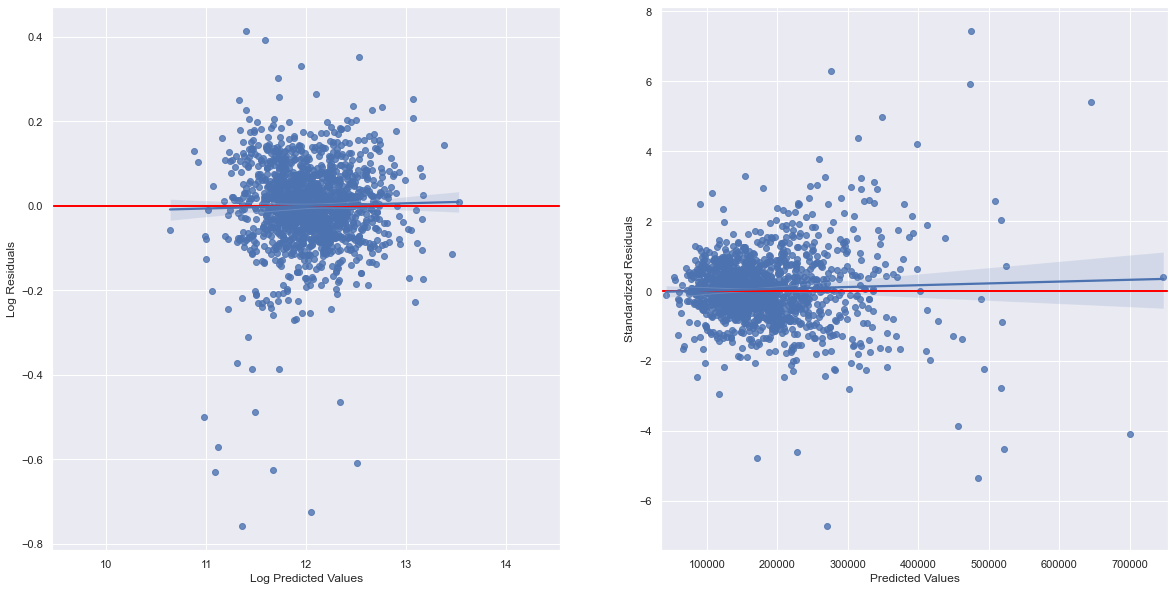

In [12]:
###CREACION DEL PIPELINE PARA BUSCAR PARAMETROS Y ENTREGAR RESULTADOS EN EL TEST SET
##Se evalúa y luego sehace un plot de residuos para analizarlos
"""Análisis residual: recordar que el plot debe mostrar que los residuos no están distribuídos con ningún patrón discernible,
ya que de otro modo significaría que no representan el error estocástico (que nose puede predecir)
y todavía hay ahí información que el modelo debe capturar"""
"""Links para repasar analisis residual :
Muy bien explicado: https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/
Otros:
https://www.analyticsvidhya.com/blog/2013/12/residual-plots-regression-model/
https://blog.minitab.com/blog/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis
"""

"""Estructura general de gridsearch:

gs = modelo_a_entrenar + parámetros_a_combinar_para_buscar + refit(una vez que se encuentren los óptimos se reentrena y se usa
el scoring de evaluación que acá le diga) + scoring (todos los scoring de evaluación que le pediré que use para elegir) + cv(Nro de folds para cvalidation+
verbose(si va contando lo que va pasando o no)) 

"""

##Modelo a entrenar
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', Lasso(random_state = 101))]) #primero le hago una reduccion de dimensionalidad vía PCA

##Configuro los parámetros a combinar (acá el viejo ya probó varios y quedó con esta combinación. SE DEBE PROBAR TAMBIÉN)

SEL = list(set(sel_cols_rfecv).union(set(new_poly_features.columns))) #Por cada modelo elegiré el set de features seleccionado en etapa anterior
n_components = [len(SEL)-5, len(SEL)-3, len(SEL)] 
whiten = [False, True]
max_iter = [5] #, 10, 100, 200, 300, 400, 500, 600]  
alpha = [0.0003, 0.0007, 0.0005, 0.05, 0.5, 1.0]
selection = ['random', 'cyclic'] 
tol = [2e-03, 0.003, 0.001, 0.0005]
param_grid =\
            dict(
                  model__alpha = alpha
                  ,model__max_iter = max_iter
                  ,model__selection = selection
                  ,model__tol = tol
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                ) 

#Armado del gs:
gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

##Armado del Pipeline general

lasso = Pipeline([
        ('sel', select_features(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

##Fit del pipeline

lasso.fit(train,y_train)

###Obtención de resultados y plots para análisis residual:

results = get_results(lasso, 'lasso Lg1', log=True) #Notar se elige log = true porque que target estaba log transformed
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = residuals_plots(lasso, train, y_train, log=True)

In [ ]:
###ANALISIS:
"""
1. Resultados: Puede verse que los scores óptimos obtenidos son bastante buenos, con un RMSE de 0.116 y un R2 de 92.4%
2. Outliers: en el plt de log se ven algunos puntos que se escapan demasiado del centro y que podrían ser outliersm aunque no son mayores 
que 0.42 ni menores que -0.8. Valdría la pena analizar cómo se comporta el modelo sin ellos
2. Análisis residual:
- Si bien en el plot de la izquierda (log) no se ven patrones tan evidentes, en el plot de residuos estandarizados se puede 
notar patrones que dan una forma de embudo (funnel)
- Recordar que se utilizó el target log transformed, lo cual logró mejorar su normalidad (bajo skew) pero igual mirando el plot 
de std se ve que hay clara heteroskedasticity y un patron discernible. 
- Por lo anterior será bueno analizar cómo se comporta el modelo con outliers recortados y si hay una diferencia
entrenado con target sin log transform

"""

In [13]:
##Analizar con outliers recortados
"""Recortaremos dejando data con valores absolutos no mayores a 0.3 arriba y abajo"""

recortados = list(r["IDX"][abs(r["Residual"]) <= 0.3]) # me deja todos los indices de los datapoints que quedan dentro
print("Outliers removed:{}".format(r.shape[0] - len(recortados)))



Outliers removed:18


Received 190 features...
Select 109 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:    6.4s finished


Best Score: 0.094190
---------------------------------------
Best Parameters:
{'model__alpha': 0.0007, 'model__max_iter': 5, 'model__selection': 'cyclic', 'model__tol': 0.002, 'pca__n_components': 106, 'pca__whiten': True}


,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,75,-6.9282,0.3754,-13.6090,0.5641
0,R2,51,94.5765,0.4401,70.8932,0.6116
0,RMSE,75,0.0942,0.0235,0.2323,0.0600


Select 109 features


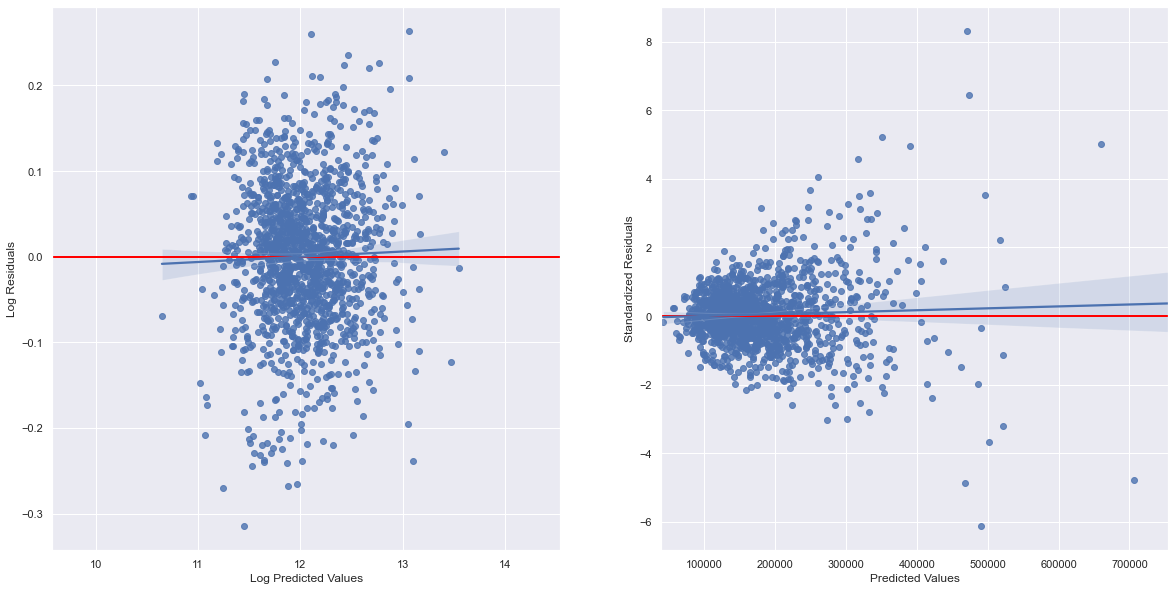

In [14]:
#Preparo nuevo train e y_train
t = train.iloc[recortados, :].reset_index(drop = True, inplace = False)
y_t = y_train.iloc[recortados].reset_index(drop = True, inplace = False)

#Fit the pipeline con los datos recortados
lasso.fit(t,y_t)

###Obtención de resultados y plots para análisis residual:

results = get_results(lasso, 'lasso Lg1', log=True) #Notar se elige log = true porque que target estaba log transformed
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = residuals_plots(lasso, t, y_t, log=True)

In [15]:
#Análisis
"""Vemos que hay una mejora en los scores, sobre todo en R2 (94,6%) y RMSE con 0.0942, pero vemos que se acentuó
el funnel shape de los std residuals.

Probamos a continuación con todo el dataset pero con target sin log transform..."""



'Vemos que hay una mejora en los scores, sobre todo en R2 (94,6%) y RMSE con 0.0942, pero vemos que se acentuó\nel funnel shape de los std residuals.\n\nProbamos a continuación con todo el dataset pero con target sin log transform...'

Received 190 features...
Select 109 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:    6.8s finished


Best Score: 21505.044648
---------------------------------------
Best Parameters:
{'model__alpha': 1.0, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 106, 'pca__whiten': False}


,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,242,-1458274.4555,85475.5719,-1464803.3303,85768.2375
0,R2,242,92.5998,0.5795,92.5377,0.5271
0,RMSE,242,21505.0446,7073.2815,21599.1920,7013.2050


Select 109 features


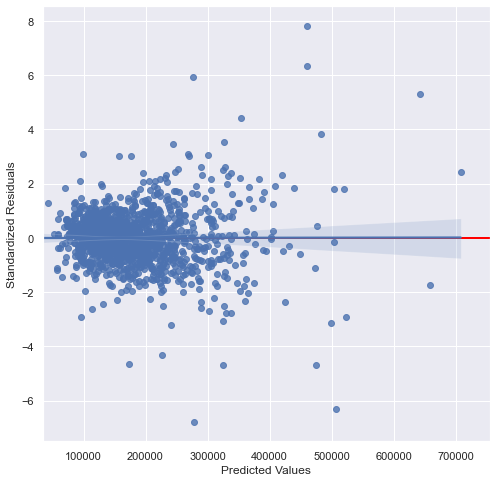

In [16]:
#Análisis con target sin transformación

#Invierto la transformación
y_n = np.expm1(y_train)

#Fit
lasso.fit(train,y_n)

###Obtención de resultados y plots para análisis residual:

results = get_results(lasso, 'lasso Lg1', log= False) 
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = residuals_plots(lasso, train, y_n, log=False) #log False

In [ ]:
"""Puede verse que no hay una mejora sustancial en los scores respecto del primer caso (R2 de 92.4% versus 92.6% de ahora).
Esto muestra que no se logra mucho trabajando con el target sin log transform. Hasta ahora el mejor resultado se obtiene 
con todo el dataset (sin recorte de outliers) y con target log transformed. Seguimos ahora con otro modelo..."""

In [17]:
##Modelo XGBRegressor:

"""Modelaremos ahora con XGBRegressor:
APRENDER MÁS:
LINKS: https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5
(información de cómo funciona el algoritmo XGBoost y qué significan sus principales parámetros)

https://www.shirin-glander.de/2018/11/ml_basics_gbm/#:~:text=Gradient%20Boosting%20Machines%20vs.,XGBoost&text=1.)&text=While%20regular%20gradient%20boosting%20uses,order%20derivative%20as%20an%20approximation.

VIDEO: https://www.youtube.com/watch?v=wPqtzj5VZus

XGBRegressor es una variante que utiliza una función de regresión en cada árbol
"""


'Modelaremos ahora con XGBRegressor:\nAPRENDER MÁS:\nLINKS: https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5\n(información de cómo funciona el algoritmo XGBoost y qué significan sus principales parámetros)\nVIDEO: https://www.youtube.com/watch?v=wPqtzj5VZus\n\nXGBRegressor es una variante que utiliza una función de regresión en cada árbol\n'

Received 190 features...
Select 109 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.0s finished


[19:34:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_depth, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Score: 19962.867906
---------------------------------------
Best Parameters:
{'model__booster': 'gblinear', 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 3500, 'model__objective': 'reg:tweedie', 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'pca__n_components': 90, 'pca__whiten': True}
Select 109 features


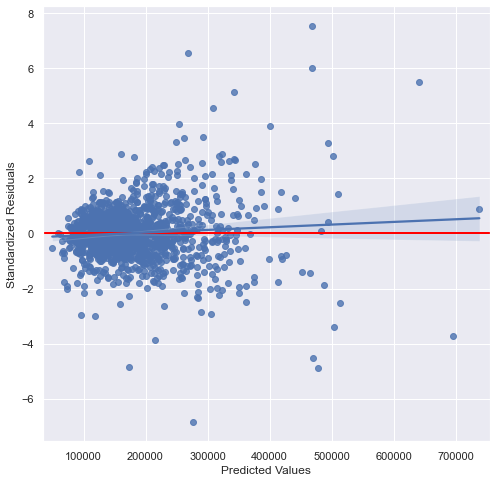

,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,0,-1333470.9143,76407.5374,-1333470.9143,76407.5374
0,R2,0,93.6140,0.5406,93.6140,0.5406
0,RMSE,0,19962.8679,6378.4026,19962.8679,6378.4026


In [37]:
##Modelo a entrenar
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', XGBRegressor(random_state = 101, silent=False))]) #silent False es que quiero mensajes

##Configuro los parámetros a combinar (acá el viejo ya probó varios y quedó con esta combinación. SE DEBE PROBAR TAMBIÉN)

SEL = list(set(sel_cols_rfecv).union(set(new_poly_features.columns))) #Uso el mismo set anterior de features
n_components = [90] #[len(SEL)-18, len(SEL)-19, len(SEL) - 20] 
whiten = [True]#False
n_est = [3500] #Nro de estimators o árboles en este caso
max_depth = [3] #max tree depth
learning_rate = [0.01] #probó con varios más
reg_lambda = [1] # lambda que acompaña en L1 regulatization (el que va con Ridge) en XGB cost function
reg_alpha = [1] # alpha que acompaña en L2 regulatization (el que va con Lasso) en XGB cost function (ver link arriba)
booster = ["gblinear"] #The booster parameter sets the type of learner. Usually this is either a tree or a linear function. In the case of trees, the model will consist of an ensemble of trees. For the linear booster, it will be a weighted sum of linear functions.
objective = ["reg:tweedie"] #reg:linear, reg:gamma


param_grid =\
            dict(
                  pca__n_components = n_components,
                  pca__whiten = whiten, 
                  model__n_estimators= n_est
                  ,model__booster = booster
                  ,model__objective = objective
                  ,model__learning_rate = learning_rate
                  ,model__reg_lambda = reg_lambda
                  ,model__reg_alpha = reg_alpha
                  ,model__max_depth = max_depth
                ) 


#Armado del gs:
gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

##Armado del Pipeline general

XGBR = Pipeline([
        ('sel', select_features(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

##Fit del pipeline

#Usaremos y_train sin log transform
y_n = np.expm1(y_train)
XGBR.fit(train,y_n)

###Obtención de resultados y plots para análisis residual:

# res = get_results(XGBR, 'XGBRegressor', log=False) # Sin log transformed
# display(res.loc[:, 'Scorer' : 'MeanScoreStd'])
# residuals_plots(XGBR, train, y_train, log= False)

res = get_results(XGBR, 'XGBRegressor', log=False)
residuals_plots(XGBR, train, y_n, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']



In [ ]:
#Análisis:
"""Puede verse que los scores de evaluación mejoran, con un RMSE de 19963 y un R2 de 93.6%. Sn embargo se sigue viendo
un notorio patrón de embudo en la gráfica de de residuos estandarizados"""

In [33]:
###GRADIENT BOOSTING REGRESSOR (GBR)

"""
Link_1 (XGBRegressor): https://blog.paperspace.com/implementing-gradient-boosting-regression-python/
Link: https://www.shirin-glander.de/2018/11/ml_basics_gbm/#:~:text=Gradient%20Boosting%20Machines%20vs.,XGBoost&text=1.)&text=While%20regular%20gradient%20boosting%20uses,order%20derivative%20as%20an%20approximation."""
"""Link implementación: https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html """ 

'Link implementación: https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html '

Received 190 features...
Select 62 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.6min finished


Best Score: 25685.147389
---------------------------------------
Best Parameters:
{'model__alpha': 0.8, 'model__criterion': 'friedman_mse', 'model__learning_rate': 0.05, 'model__loss': 'huber', 'model__max_depth': 3, 'model__max_features': 'auto', 'model__min_samples_leaf': 4, 'model__min_samples_split': 3, 'model__n_estimators': 3000, 'pca__whiten': True}
Select 109 features


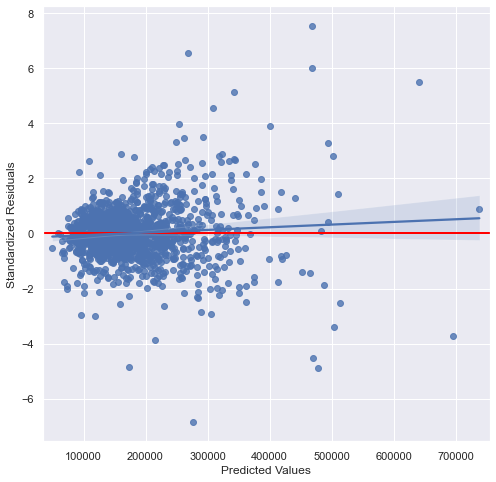

,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,0,-1708609.0745,39607.9687,-1708609.0745,39607.9687
0,R2,0,89.2939,1.6800,89.2939,1.6800
0,RMSE,0,25685.1474,5112.4337,25685.1474,5112.4337


In [40]:
##Modelo a entrenar
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', GradientBoostingRegressor(random_state = 101))]) 

##Configuro los parámetros a combinar (acá el viejo ya probó varios y quedó con esta combinación. SE DEBE PROBAR TAMBIÉN)

SEL = list(set(Xgb_selected_feats).union(set(new_poly_features.columns))) #Uso el seleccionado por XGBoost
# n_components = [90] #[len(SEL)-18, len(SEL)-19, len(SEL) - 20] 
whiten = [True]#False
n_est = [3000] #Nro de estimators o árboles en este caso
learning_rate = [0.05] #probó con varios más
loss = ["huber"] #se elige huber loss, que es una combinación de least squares regression and least absolute deviation.
max_features = ["auto"] #nr of feat to consider when looking for the best split (auto = sqrt(n_features))
max_depth = [3] #max tree depth
min_samples_split = [3]
min_samples_leaf = [4]
criterion = ["friedman_mse"] #function to measure the quality of a split
alpha = [0.8] #Complexity parameter used for Minimal Cost-Complexity Pruning


param_grid = dict(
                  #pca__n_components = n_components,
                  pca__whiten = whiten, 
                   model__n_estimators= n_est 
                  ,model__learning_rate = learning_rate
                  ,model__loss = loss
                  ,model__criterion = criterion
                  ,model__max_depth = max_depth
                  ,model__alpha = alpha
                  ,model__max_features = max_features
                  ,model__min_samples_split = min_samples_split
                  ,model__min_samples_leaf = min_samples_leaf
                   )


#Armado del gs:
gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

##Armado del Pipeline general

GBR = Pipeline([
        ('sel', select_features(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

##Fit del pipeline

#Usaremos y_train sin log transform
y_n = np.expm1(y_train)
GBR.fit(train,y_n)

###Obtención de resultados y plots para análisis residual:


res = get_results(GBR, 'GBR', log=False)
residuals_plots(XGBR, train, y_n, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

In [41]:
#Analisis:
# Los scores son bastante pobres, con un R2 de sólo 89,3%
#The residual plots still shows a discernible funnel pattern. 

In [45]:
### ELASTICNET
"""Elasticnet combina en su funcion de costo a Ridge y Lasso
Link: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet """

'Elasticnet combina en su funcion de costo a Ridge y Lasso\nLink: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elasticnet#sklearn.linear_model.ElasticNet '

![image] https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543418448/eq12_vh6ilt.png


Received 190 features...
Select 109 features
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    2.7s finished


Best Score: 21395.996521
---------------------------------------
Best Parameters:
{'model__alpha': 1e-05, 'model__l1_ratio': 3e-05, 'model__max_iter': 5, 'model__selection': 'cyclic', 'pca__n_components': 109, 'pca__whiten': False}
Select 109 features


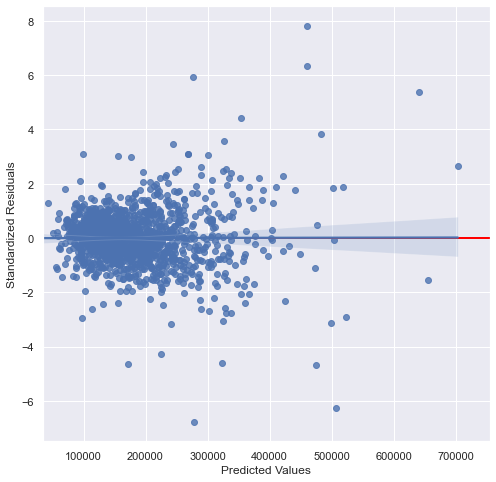

,Scorer,Index,BestScore,BestScoreStd,MeanScore,MeanScoreStd
0,MAE,2,-1454591.4852,85528.6324,-1455092.2211,85865.2166
0,R2,2,92.6726,0.6286,92.6690,0.6336
0,RMSE,2,21395.9965,7175.4011,21401.3962,7197.2717


In [46]:
##Modelo a entrenar
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', ElasticNet(random_state = 101))]) 

##Configuro los parámetros a combinar (acá el viejo ya probó varios y quedó con esta combinación. SE DEBE PROBAR TAMBIÉN)

SEL = list(set(sel_cols_rfecv).union(set(new_poly_features.columns)))  #Uso el seleccionado por RFEcv
n_components = [len(SEL)- 5 , len(SEL)- 3, len(SEL)] 
whiten = [False]
max_iter = [5] #100
alpha = [1e-05] #parámetro alpha multiplica la sección que combina L1 y L2. Ver fórmula en link-imagen  de arriba
l1_ratio = [0.00003] # The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
selection = ["cyclic"] #todos los coeficientes se actualizan con cada vuelta (random sería uno solamente)

param_grid =\
            dict(
                  model__max_iter= max_iter
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                  ,model__alpha = alpha
                  ,model__l1_ratio = l1_ratio
                  ,model__selection = selection
               ) 





#Armado del gs:
gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

##Armado del Pipeline general

ELA = Pipeline([
        ('sel', select_features(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

##Fit del pipeline

#Usaremos y_train sin log transform
y_n = np.expm1(y_train)
ELA.fit(train,y_n)

###Obtención de resultados y plots para análisis residual:


res = get_results(ELA, 'ELA', log=False)
residuals_plots(ELA, train, y_n, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

In [47]:
###Analysis: 
#En general dio buenos resultados en scores siendo además bien livianito
#Menos notorios los patrones lineales en el plot de std residuals

In [48]:
##BAYESIAN RIDGE REGRESSION